In [1]:
import pytraj as pt
import matplotlib.pyplot as plt
from glob import glob
import pandas as pd
import seaborn as sns
import numpy as np
#import mdpath
import pathlib
#import vmd
import MDAnalysis as mda
import MDAnalysis
from MDAnalysis.analysis import rdf
from MDAnalysis import *
import MDAnalysis.analysis.msd as msd

#from vmd import molecule
#import pytraj_analysis
%matplotlib inline

In [3]:
import pickle # for saving dict
from scipy.stats import linregress # linear regression
import statistics


In [94]:
plt.rcParams['font.sans-serif'] = 'Arial'
plt.rcParams['xtick.labelsize'] = 16
#plt.rcParams['xtick.major.size'] = 3
#plt.rcParams['xtick.major.width'] = 2
#plt.rcParams['xtick.minor.size'] = 5
plt.rcParams['ytick.labelsize'] = 16
#plt.rcParams['ytick.major.width'] = 1
#plt.rcParams['ytick.minor.size'] = 5
#plt.rcParams['figure.figsize'] =  (30, 30)
plt.rcParams['axes.titlesize'] = 18

plt.rcParams['axes.labelsize'] = 16
#plt.rcParams['axes.labelsize'] = 16

plt.rcParams['axes.grid'] = False
# Resolution
# Legend Parameters
plt.rcParams['figure.dpi'] = 300
plt.rcParams['legend.fontsize'] = 16

# Load the xyz coord of bromoform molecules

In [53]:
# load the saved dict list
## bromo_coord record the xyz coordinates of the bromoforms over 1000 frames
with open('Z_coord_bromo_pene_unwrap_5.pkl', 'rb') as f:
    bromo_coord = pickle.load(f)

In [54]:
bromo_coord.shape

(1000, 55)

In [55]:
bromo_coord[:,3::3]

array([[ -9.56180859, -32.58369827, -22.00876045, ..., -15.51813126,
        -13.2319355 , -20.81275368],
       [ -9.44336414, -32.57316971, -21.98226166, ..., -15.32956696,
        -13.25075722, -20.96421051],
       [ -9.34993362, -32.58156967, -21.98423958, ..., -15.29541683,
        -13.15853119, -21.06000137],
       ...,
       [ -6.96050024, -32.63489151, -19.03166008, ..., -15.50763702,
        -19.38573837, -21.26439285],
       [ -6.93849611, -32.77841187, -19.18221283, ..., -15.54603004,
        -19.46372795, -21.23210526],
       [ -6.92490292, -32.74568558, -19.28953552, ..., -15.68732643,
        -19.34374428, -21.2047863 ]])

## Function for Overlapping Window Method

In [58]:
def MSD_overlap(data,n,N,msd_type):

    """
    data column: time|x1|y1|z1|...xm|ym|zm
    N: row of data/length of traj
    n: size of small window/range of MSD
    msd_type: x/y/z/xyz
    """

    if N != data.shape[0]:
        print("WARNING: n_row does not match input N value!!")
        
    n_col = data.shape[1] -1
    n_mol = int(n_col/3)
    
    if msd_type=='x':
        ## create SD:
        SD = []
        for i in range(n):
            SD.append([])
        
       # extract x coord
        x_data = data[:,1::3]
        
        for i in range(n_mol):  # number of bromo molecules
            for j in range(N-n+1):  ## number of overlapping windows
                for k in range(n):  # over the small windown length
                    if k == 0:
                        SD[k].append(0)
                    else:
                        sd_k = (x_data[j+k,i] - x_data[j,i]) ** 2
                        SD[k].append(sd_k)
 
        MSD = [ sum(list_i)/len(list_i)  for list_i in SD]
    
    if msd_type=='y':
        ## create SD:
        SD = []
        for i in range(n):
            SD.append([])
        
       # extract y coord
        y_data = data[:,2::3]
        
        for i in range(n_mol):  # number of bromo molecules
            for j in range(N-n+1):  ## number of overlapping windows
                for k in range(n):  # over the small windown length
                    if k == 0:
                        SD[k].append(0)
                    else:
                        sd_k = (y_data[j+k,i] - y_data[j,i]) ** 2
                        SD[k].append(sd_k)
 
        MSD = [ sum(list_i)/len(list_i)  for list_i in SD]
    
    if msd_type=='z':
        ## create SD:
        SDz = []
        for i in range(n):
            SDz.append([])
        
       # extract z coord
        z_data = data[:,3::3]
        
        for i in range(n_mol):  # number of bromo molecules
            for j in range(N-n+1):  ## number of overlapping windows
                for k in range(n):  # over the small windown length
                    if k == 0:
                        SDz[k].append(0)
                    else:
                        sd_k = (z_data[j+k,i] - z_data[j,i]) ** 2
                        SDz[k].append(sd_k)
 
        MSD = [ sum(list_i)/len(list_i)  for list_i in SDz]
   
    if msd_type =='xyz':
        SD = []
        for i in range(n):
            SD.append([])
        
       # extract xyz coord
        x_data = data[:,1::3]
        y_data = data[:,2::3]
        z_data = data[:,3::3]
        
        for i in range(n_mol):  # number of bromo molecules
            for j in range(N-n+1):  ## number of overlapping windows
                for k in range(n):  # over the small windown length
                    if k == 0:
                        SD[k].append(0)
                    else:
                        sd_k = (x_data[j+k,i] - x_data[j,i]) ** 2
                        sd_k += (y_data[j+k,i] - y_data[j,i]) ** 2
                        sd_k += (z_data[j+k,i] - z_data[j,i]) ** 2
                        SD[k].append(sd_k)
 
        MSD = [ sum(list_i)/len(list_i)  for list_i in SD]
        
    return np.asarray(MSD, dtype=np.float32)
    

In [59]:
n_window= 500 # size of window



## MSD at Z-dir

In [60]:
MSD_z = MSD_overlap(bromo_coord,n=n_window,N=1000,msd_type='z')

MSD_z.shape

(500,)

### get the slope and std with linear fitting

In [62]:
from scipy.stats import linregress # linear regression

## define linear range
istart = 100
iend = 450

linear_model_z = linregress(lagtimes[istart:iend], MSD_z[istart:iend])
slope = linear_model_z.slope
error = linear_model_z.rvalue
stderr = linear_model_z.stderr

    # dim_fac is 1 as we computed a 1D msd with 'z'
dim_fac = 1
D_z = slope * 1/(2*dim_fac)  # \AA^2/ps

# convert unit to cm^2/s
D_z_convert = D_z/10000
    #D_b_convert = D_b/10000
print(D_z_convert)
#D_z_list.append(D_z_convert)
#D_z_err.append(stderr/2/10000)

stderr_convert = stderr * 1/(2*dim_fac)  # \AA^2/ps
stderr_convert /= 10000

print(f"{D_z_convert:.2} \u00B1 {stderr_convert:.2}")



1.7895542500893084e-06
1.8e-06 ± 2.1e-08


## Do the same for X and Y dir

In [63]:
MSD_x = MSD_overlap(bromo_coord,n=n_window,N=1000,msd_type='x')
MSD_y = MSD_overlap(bromo_coord,n=n_window,N=1000,msd_type='y')

In [92]:
from scipy.stats import linregress # linear regression

## define linear range
istart = 10
iend = 390

linear_model_x = linregress(lagtimes[istart:iend], MSD_x[istart:iend])
slope = linear_model_x.slope
error = linear_model_x.rvalue
stderr = linear_model_x.stderr

    # dim_fac is 1 as we computed a 1D msd with 'z'
dim_fac = 1
D_x = slope * 1/(2*dim_fac)  # \AA^2/ps

# convert unit to cm^2/s
D_x_convert = D_x/10000
    #D_b_convert = D_b/10000
print(D_x_convert)
#D_z_list.append(D_z_convert)
#D_z_err.append(stderr/2/10000)

stderr_convert = stderr * 1/(2*dim_fac)  # \AA^2/ps
stderr_convert /= 10000

print(f"{D_x_convert:.2} \u00B1 {stderr_convert:.2}")





6.008502671425741e-06
6e-06 ± 6.1e-08


In [82]:
from scipy.stats import linregress # linear regression

## define linear range
istart = 10
iend = 380

linear_model_y = linregress(lagtimes[istart:iend], MSD_y[istart:iend])
slope = linear_model_y.slope
error = linear_model_y.rvalue
stderr = linear_model_y.stderr

    # dim_fac is 1 as we computed a 1D msd with 'z'
dim_fac = 1
D_y = slope * 1/(2*dim_fac)  # \AA^2/ps

# convert unit to cm^2/s
D_y_convert = D_y/10000
    #D_b_convert = D_b/10000
print(D_y_convert)
#D_z_list.append(D_z_convert)
#D_z_err.append(stderr/2/10000)

stderr_convert = stderr * 1/(2*dim_fac)  # \AA^2/ps
stderr_convert /= 10000

print(f"{D_y_convert:.2} \u00B1 {stderr_convert:.2}")



6.24621168999032e-06
6.2e-06 ± 9.7e-08


# Plot all three

Text(0, 0.5, 'MSD ($\\AA^2$)')

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Generic family 'sans-serif' not found because none of the following families were found: Arial


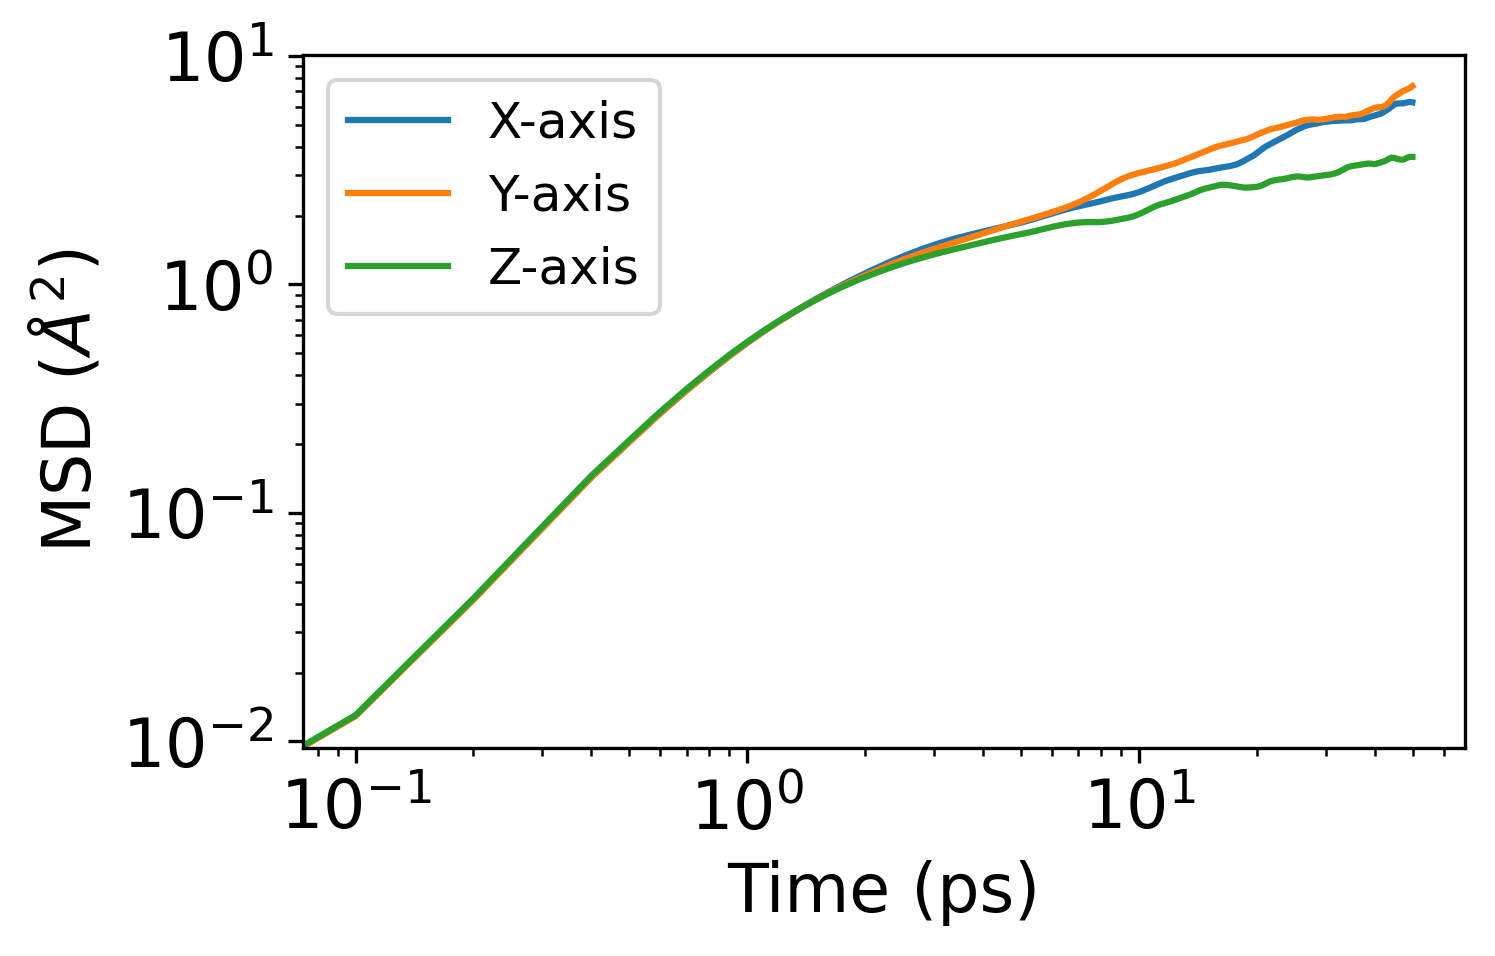

In [95]:
xlabel = "Time (ps)"
ylabel = "MSD ($\AA^2$)"

time_per_frame = 0.1 # unit ps
stride = 1 #
timestep = time_per_frame * stride # unit ps
nframes = n_window
lagtimes = np.arange(nframes)*timestep # make the lag-time axis



figure, ax = plt.subplots(figsize=(5,3))

#ax.scatter(lagtimes, MSD_z,s=0.05)
ax.plot(lagtimes, MSD_x,label="X-axis")
ax.plot(lagtimes, MSD_y,label="Y-axis")
ax.plot(lagtimes, MSD_z,label="Z-axis")

ax.legend(loc='best',fontsize=12)
# Set the x and y axes to logarithmic scale
plt.xscale('log')
plt.yscale('log')

ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel)